# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Physical modelling</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal

import import_ipynb
from Helpers import * 

import matplotlib
figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16});

importing Jupyter notebook from Helpers.ipynb


In [2]:
fs=44100

## 1. Karplus–Strong string synthesis

A rather easy model for synthesizing a string was proposed in 1983 in the article "Digital Synthesis of Plucked String and Drum Timbres" by Karplus and Strong. It defines the string as being a very short noise generator followed by a lowpass loop. The delay of the loop determines the frequency of the string, and the length of the noise burst the "precision" of the picking of the string. Hence, a short noise burst would generate a rather "striked string" sound, corresponding to instruments such as the harpsicord, while longer noise burst would create a more "bowed string" sound, such as a violin.

The diagram is as follows

<img src="pictures/strong.png" alt="Drawing" style="width: 60%;"/>

where the lowpass filter is typically implement using a simple moving average over the past samples. The size of the moving average influences the dampening of the string over time.

The value $N$ (in samples) of the delay is simply calculated by (euclidean) dividing the sampling frequency $f_s$ by the desired string frequency $f$,
$$
N = \lfloor fs /f \rfloor .
$$

Let's implement it!

In [3]:
def karplus_strong(freq, pinch=.02, sustain=.99, dampen=2, duration=2, lowpass=False):
    """
    Plays a string sound using the Karplus-Strong model.
    freq: the frequency (in hertz) of the played string
    pinch: the length (in seconds) of the initial pinching of the string
    sustain: the sustain factor of the vibration of the string after the pinching (1 is normal sustain)
    dampen: the level of dampening of the string (1 = no dampen, higher int values is more dampen)
    duration: the duration of the output sound in seconds
    lowpass: apply a lowpass to the output signal
    returns: a numpy array containing the vibrating string's data
    """
    out = np.zeros(int(duration*fs)) # placeholder for the output
    burst = 2*np.random.random(int(pinch*fs)) - 1 # Random noise in [-1, 1] lasting pinch ms
    out[:int(pinch*fs)] = burst # output starts with burst
    
    delay = int(fs//freq) # delay of the loop (in samples)
    for i in range(delay, int(duration*fs)): # delay loop
        out[i] += sustain * np.mean(out[i-delay:i-delay+dampen])
        
    if lowpass: out = butter_pass_filter(out, np.array([int(10*freq)]), fs, "low", order=1)
    return normalize(out)

Let's test it with a 200Hz frequency.

In [4]:
string = karplus_strong(150, lowpass=True)

Audio(string, rate=fs)

Sounds quite synthetic, but given the simplycity of the code above, this is already quite good! Let's have a look at the frequencies and try playing with them.

In [5]:
@widgets.interact(freq=(50, 500, 50), pinch=(0.1, 0.5, 0.1), sustain=(.98, 1, 0.001), damper=(1, 10, 1))
def update(freq=200, pinch=.02, sustain=.99, damper=2,):
    
    test = karplus_strong(freq, pinch, sustain, damper, duration=2)

    plt.figure(figsize=figsize)
    plt.plot(test)
    plt.xlabel("Time [samples]")
    plt.show()

    plt.figure(figsize=figsize)
    plt.magnitude_spectrum(test)
    plt.xlim(0, .3)
    plt.show()

interactive(children=(IntSlider(value=200, description='freq', max=500, min=50, step=50), FloatSlider(value=0.…

The frequency spectrum is quite rich already. Try playing with the sliders and observe how each parameter influences the spectrum.

### 1.1. Play a song!

We can now test our guitar with the Pacman melody from the 1-bit music notebook. To this extent, we simply need to convert it to a function that can be pass to the melody player from this notebook, i.e. a function taking only an angular frequency $\omega$ and a length $N$ in samples.

In [6]:
%%capture
from OneBitMusic import play_notes

In [7]:
def guitar(w,N):
    return karplus_strong(w*fs/2/np.pi, pinch=.02, sustain=.995, dampen=2, duration=N/fs, lowpass=True)

Play it, Jonnie!

In [8]:
tune = (('B4', 2), ('B5', 2), ('F#5', 2), ('D#5', 2), ('B5', 1), ('F#5', 3), ('D#5', 4), 
        ('C5', 2), ('C6', 2), ('G5', 2),  ('E5', 2),  ('C6', 1), ('G5', 3),  ('E5', 4),
        ('B4', 2), ('B5', 2), ('F#5', 2), ('D#5', 2), ('B5', 1), ('F#5', 3), ('D#5', 4), 
        ('D#5', 1), ('E5', 1), ('F5', 2), ('F5', 1), ('F#5', 1), ('G5', 2), ('G5', 1), 
        ('G#5', 1), ('A5', 2), ('B5', 4))

jingle = play_notes(tune, time_scale=0.02, rate=4*fs, wave_engine=guitar)
Audio(jingle, rate=fs)

## 2. Drums

### 2.1. Kick

Physically, a kick (a bass drum) is a large drum, around 20 inches in diameter, one side of it, the beat drum head, being hit with a hammer generally attached to a pedal, or hold in hand. The other side is covered with another drum head for resonance. The tension of the drum heads can be controlled with screws, and is tuned to optimally resonate with the geometry of the drum. When the hit by the hammer, t A simple way to model a kick is to generate a sine sweep that starts at a high pitch, around 14kHz, and then quickly goes down to a lower pitch at 20Hz and stays there for 200ms. Simply multiply this by the envelope described above and you obtain a very recognizable electronic kick sound. One can model toms and other kinds of simple drum in a similar fashion by using different start and end frequencies for the sweep. Similarly, the resonance of the drum can be tuned by the length of the sweep and the envelope. For instance, the 1980s saw a prominence in the popularity of headless drums, bass drums without a resonance drum head, generating shorter, more precise kicks.he tension in the drum head increase briefly generating a very short (around 20ms) high pitch noise. This initial "burst" contributes to the attack (the "kick") of the bass drum sound. As the beating ends, the vibration of the drum head continues with a lower tension, resulting in a lower pitch that immediately follows the first "burst", and fades away after 200ms.

<img src="https://d1aeri3ty3izns.cloudfront.net/media/49/499096/1200/preview.jpg" alt="Drawing" style="width: 30%;"/>

A simple way to model a kick is to generate a sine sweep that starts at a high pitch, around 14kHz, and then quickly goes down to a lower pitch at 20Hz and stays there for 200ms. 

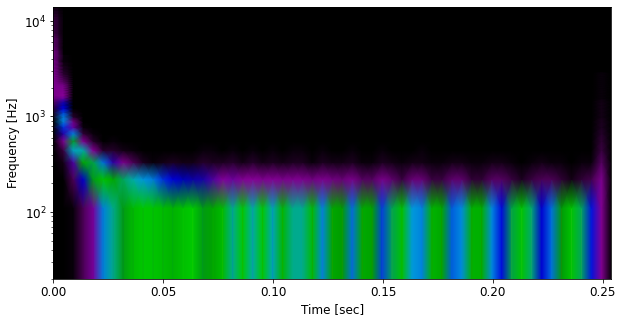

In [9]:
t = np.linspace(0, 1/4, int(fs/4))
sweep = signal.chirp(t, f0=14000, t1=.25, f1=20, method="hyperbolic")

# Plot
f, t, Zxx = signal.stft(sweep, fs, nperseg=400)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='nipy_spectral', shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(20, 14000)
plt.yscale("log")
#plt.savefig("kick_stft.pdf", dpi=150, bbox_inches='tight')
plt.show()

Amplitude-wise, a kick as a fast attack, going from 0 to 1 during the initial burst phase. Then, as soon as the resonance phase starts, the amplitude decreases logarithmically back to 0 until 200ms.

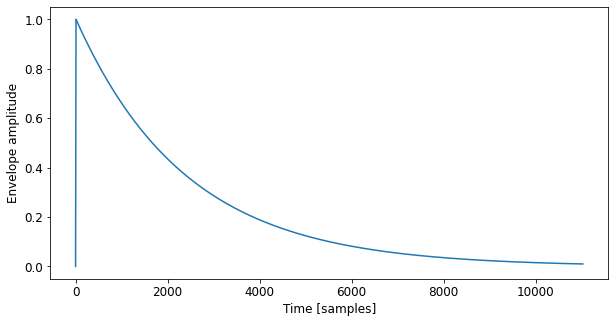

In [10]:
envelope = np.ones(sweep.size) 
envelope[:10] = np.linspace(0,1,10)
envelope[10:] = np.logspace(0, -2, envelope.size-10)

plt.figure(figsize=figsize)
plt.plot(envelope)
plt.xlabel("Time [samples]")
plt.ylabel("Envelope amplitude")
#plt.savefig("kick_env.pdf", dpi=150, bbox_inches='tight')
plt.show()

Simply multiply this by the envelope described above and you obtain a very recognizable electronic kick sound. One can model toms and other kinds of simple drum in a similar fashion by using different start and end frequencies for the sweep. Similarly, the resonance of the drum can be tuned by the length of the sweep and the envelope. For instance, the 1980s saw a prominence in the popularity of headless drums, bass drums without a resonance drum head, generating shorter, more precise kicks.

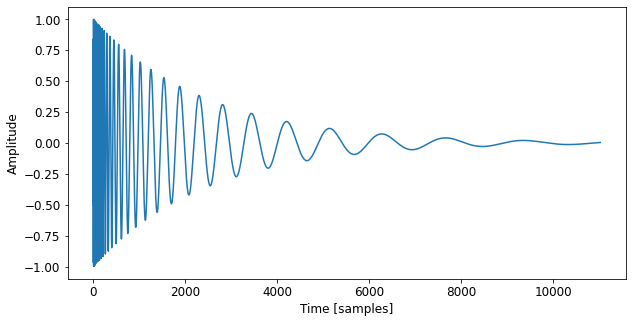

In [11]:
kick = normalize(sweep * envelope)

plt.figure(figsize=figsize)
plt.plot(kick)
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
#plt.savefig("kick.pdf", dpi=150, bbox_inches='tight')
plt.show()

Audio(kick, rate=fs)

There we go! An amazing tekno-hardcore sounding kick! A couple more steps and we're ready for the rave.

### 2.2. Snare

A snare drum is a drum with the particularity if being flatter than other drums (typically 7 inches), and to feature drums (hence the name) on the resonance drum head. Both drum heads of the snare are generally stretched with a higher tension than the other drums. The flatness of the snare generate a very sharp, short tom-like sound, while the drums add to the snare sound its signature noise sound.

<img src="https://www.collinsdictionary.com/images/full/snaredrum_233695612_1000.jpg" alt="Drawing" style="width: 30%;"/>

To model a simple snare, we will use 2 components: a noise sound modelling the snares, and a sine wave modelling the resonance of the snare drum's body. The noise is a filtered white noise with frequencies concentrated between 100 and 2000Hz. 

In [12]:
length = int(fs/4)

noise = 2*np.random.random(length) - 1
noise = butter_pass_filter(noise, np.array([10, 2000]), fs, "band", order=1)

Audio(noise, rate=fs)

The sine is a simple 100Hz wave with length 1/4 seconds. Note that for a snare drum, the drum heads are sufficiently tight so that we do not observe the logarithmic swipe effect as in the bass drum, hence a simple sine is enough. Let us import our sine wave generator from the Synthesizer notebook.

In [13]:
%%capture
from Synthesizer import sine

In [14]:
my_sine = sine(1, 100/fs*2*np.pi, 0, np.arange(length))
Audio(my_sine, rate=fs)

Both the noise and the sine are then passed through a respective envelope, with a shape similar to the bass drum's. The envelope of the noise ends shorter than the envelope of the sine, as the snares stop vibrating before the heads themselves. 

In [15]:
envelope_n = np.ones(length) 
envelope_n[:10] = np.linspace(0,1,10)
envelope_n[10:] = np.logspace(0, -3, envelope_n.size-10)

envelope = np.ones(length) 
envelope[:10] = np.linspace(0,1,10)
envelope[10:] = np.logspace(0, -2, envelope.size-10)

We finally simply add the noise with the sine, with more noise than sine. 

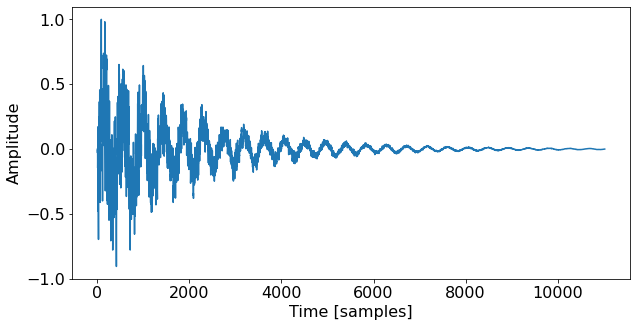

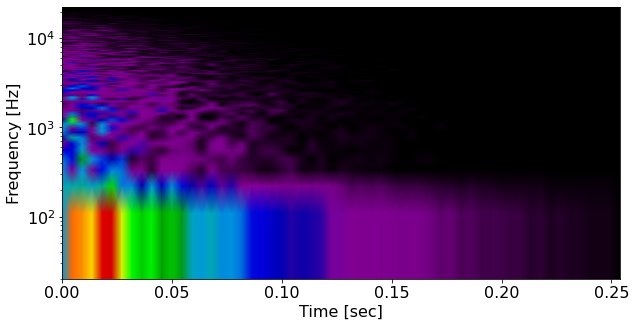

In [16]:
snare = normalize( 0.8*envelope_n*noise + 0.2*envelope*my_sine )

plt.figure(figsize=figsize)
plt.plot(snare)
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
#plt.savefig("snare.pdf", dpi=150, bbox_inches='tight')
plt.show()

# Plot
f, t, Zxx = signal.stft(snare, fs, nperseg=400)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='nipy_spectral', shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(20, 22500)
plt.yscale("log")
#plt.savefig("snare_stft.pdf", dpi=150, bbox_inches='tight')
plt.show()

Audio(snare, rate=fs)

### 2.3. Hats

Cymbals are worked plates of bronze whose usage is very versatile in a drumset. Some cymbals are used to lead the rhythm of the music, while some are used to highlight accents on some particular beats. Among the cymbals, the hi-hat is probably the most important one. It consists in 2 cymbals facing each other, mounted on a stand that allows to control the distance between the cymbals using a pedal. If the distance is large, the hi-hat is said to be open and the cymbals can resonate. If the distance is small, i.e. the cymbals touch each other, the hi-hat is said to be closed and the sound is more precise and muffled.

<img src="https://static.keymusic.com/products/240938/XL/sabian-xsr-rock-hihat-14.jpg" alt="Drawing" style="width: 30%;"/>

Modelling cymbals can actually be done fairly easily. One can simply generate a white noise and filter it to only keep the high frequencies. The higher the filter, the crispier the sound of the cymbal. Then, a similar envelope as before can be added to control the precision of the cymbal. A short envelope would create a closed hi-hat sound, while a longer envelope would generate an open hi-hat/normal cymbal sound.

In [17]:
length = int(fs/6)

noise = 2*np.random.random(length) - 1
noise = butter_pass_filter(noise, np.array([8000]), fs, "high", order=3)

envelope = np.ones(length) 
envelope[:10] = np.linspace(0,1,10)
envelope[10:] = np.logspace(0, -2, envelope.size-10)

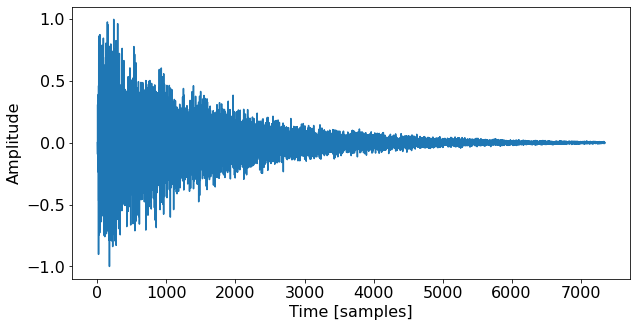

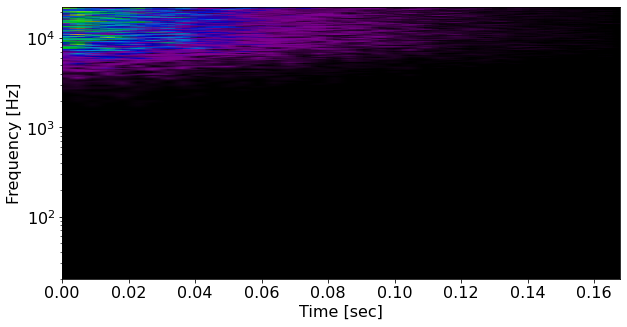

In [18]:
hihat = normalize(envelope * noise)

plt.figure(figsize=figsize)
plt.plot(hihat)
plt.xlabel("Time [samples]")
plt.ylabel("Amplitude")
#plt.savefig("hihat.pdf", dpi=150, bbox_inches='tight')
plt.show()

# Plot
f, t, Zxx = signal.stft(hihat, fs, nperseg=400)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='nipy_spectral', shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(20, 22500)
plt.yscale("log")
#plt.savefig("hihat_stft.pdf", dpi=150, bbox_inches='tight')
plt.show()

Audio(hihat, rate=fs)

### 2.4. Creating a drum beat

Using these 3 drum "samples", we can now create our own drum beat! To this extent, let us first implement a function to generate audio sequences given a boolean array indicating on which beats to play a note or not.

In [19]:
def beat_maker(pattern, sample, bpm=160):
    """
    1-track beat rhythm generator.
    pattern: the 0/1 pattern of the track (0 is no beat, 1 is beat)
    sample: the sample to use for the track
    bpm: the bpm (speed) of the rhythm
    return: an audio track of the played rhythm
    """
    out = np.zeros( int(fs * pattern.size /(bpm/60)) )
    for i in range(pattern.size):
        if pattern[i]: 
            k = int( i * fs /(bpm/60) )
            out[k:np.minimum(out.size, k+sample.size)] += sample[:np.minimum(sample.size, out.size-k)]
            
    return out

Using that function, we can now write a track for all 3 drum elements, and merge them together!

In [20]:
bpm=1000

hats   = beat_maker(np.array([1,0,0,0,1,1,1,1,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1,0]), hihat, bpm)
kicks  = beat_maker(np.array([1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0]), kick,  bpm)
snares = beat_maker(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]), snare, bpm)

beat = normalize(.7*hats + .3*kicks + snares)

Pretty sick (or cringe...), right? Note how easy it is to create a *trap* beat by simply putting a lot of fast hats together. A possible improvement of our little rhythm creator would be to be able to control the pitch and amplitude of each sample independetly, allowing to create even more *trappy* beats. let's look at it in the frequency domain.

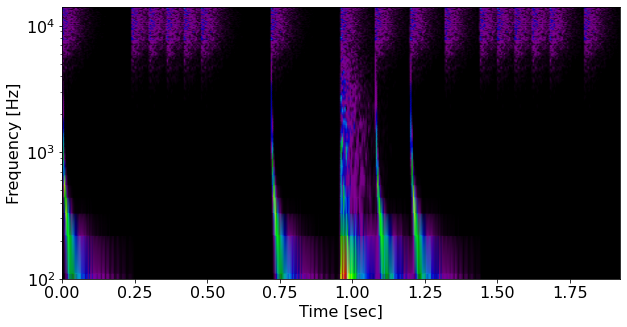

In [21]:
# Plot
f, t, Zxx = signal.stft(beat, fs, nperseg=400)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='nipy_spectral', shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(100, 14000)
plt.yscale("log")
plt.show()

Audio(beat, rate=fs)

## 3. Wind instruments

Finally, let us try to modelize a simple wind instrument, like a trumpet. Wind intruments have the particularity that as long as the musician blows in it, it keeps playing at a constant volume. However, a normal person generally does not perfectly blows an even amount of air over time. This results in light variations in the pitch of the instrument over time, quite typical of wind instruments.

Amplitude-wise, the musician has to start blowing air as precisely as possible in the trumpet to start making a sound. There again, as precise as one can be, it will still be less precise than plucking a string, hence wind intruments typically have a longer attack and release than other instruments.

<img src="https://images-na.ssl-images-amazon.com/images/I/712ZyImPK8L._AC_SL1500_.jpg" alt="Drawing" style="width: 40%;"/>

Let us now start to implement it! The first thing we need is a bright, clear synthetic sound. The saw wave we implemented in the synthesizer notebook would be a good fit.

In [22]:
%%capture
from Synthesizer import saw

Before moving the generating an actual sound, let us think of what we need. Above, we discussed that the pressure in the intrument is not constant while playing. Actually, when we start playing the trumpet, the air pressure quickly increases, but still in an audible way. This results in a quick raise in pitch as we start playing. It is also popular to add another pitch change from above this time, creating more "breath" in the initial sound attack. This can be modelled by a pitch envelope going from below, and one from above.

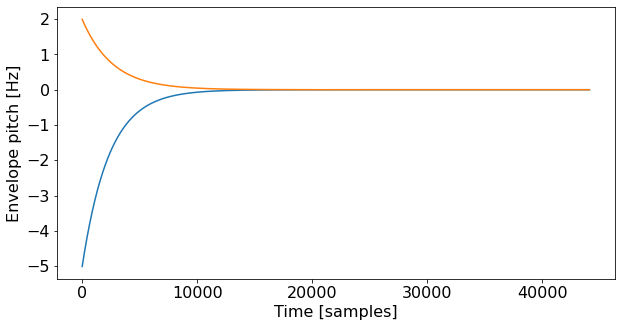

In [23]:
length = fs

# Pitch envelope 1
detune1 = np.zeros(length) 
detune1[:20000] = -np.logspace(.7, -3 ,20000)

# Pitch envelope 2
detune2 = np.zeros(length) 
detune2[:20000] = np.logspace(.3, -3 ,20000)

plt.figure(figsize=figsize)
plt.plot(detune1)
plt.plot(detune2)
plt.xlabel("Time [samples]")
plt.ylabel("Envelope pitch [Hz]")
#plt.savefig("wind_pitch_envelope.pdf", dpi=150, bbox_inches='tight')
plt.show()

The second thing we discussed is that even when the desired pitch is reached, it is hard to keep an exactly constant pressure in the instrument, resulting is very small variations in the pitch over time. This can be simply tackled by LFOs. Let's implement one for each pitch envelope above.

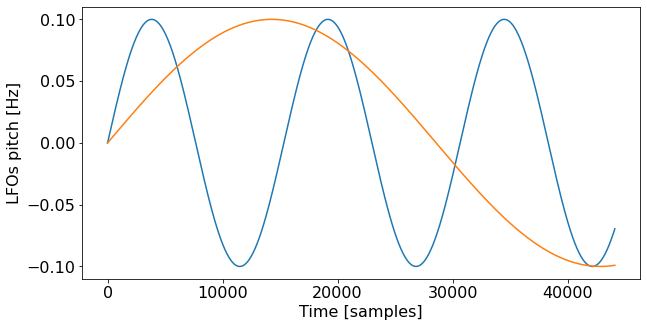

In [24]:
lfo1 = sine(.1, .00041, 0, np.arange(length)) # Low freqency oscillator 1
lfo2 = sine(.1, .00011, 0, np.arange(length)) # Low freqency oscillator 2

plt.figure(figsize=figsize)
plt.plot(lfo1)
plt.plot(lfo2)
plt.xlabel("Time [samples]")
plt.ylabel("LFOs pitch [Hz]")
#plt.savefig("kick_env.pdf", dpi=150, bbox_inches='tight')
plt.show()

Okay, we can now generate 2 saw sounds, with the pitch altered by both the LFOs and the pitch envelopes! We subsequently filter the sawteeth with a lowpass as trumpets do not generate that many frequencies about 2kHz!

In [68]:
my_saw1 = saw(1, 300/fs*2*np.pi, detune1+lfo1, np.arange(length))
my_saw1 = butter_pass_filter(my_saw1, np.array([2400]), fs, "low", order=3)

my_saw2 = saw(1, 301/fs*2*np.pi, detune2+lfo2, np.arange(length))
my_saw2 = butter_pass_filter(my_saw2, np.array([2400]), fs, "low", order=3)

Let us listen to both sawteeth together.

In [69]:
my_saw = normalize(0.7*my_saw1+0.3*my_saw2)

Audio(my_saw, rate=fs)

Sounds already not too bad, does it? A bit harsh maybe, this is because we still haven't implement the amplitude envelope. As we said, the attack is rather slow, then the sustain is constant as the player keeps blowing in the trumpet, and finally the release is quite slow too! Let us do this.

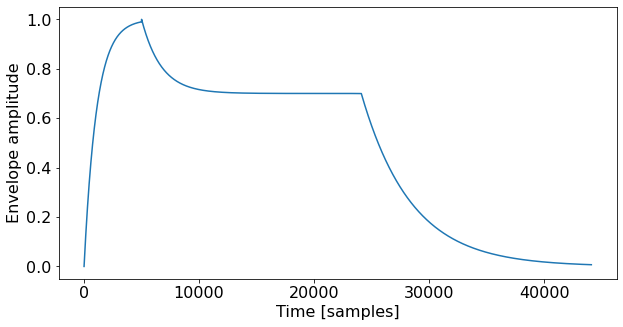

In [70]:
attack = 5000
release = 20000

envelope = np.ones(length) 
envelope[:attack] = 1 - np.logspace(0, -2 ,attack)
envelope[attack:] = 0.7 + 0.3*np.logspace(0, -10 ,length-attack)
envelope[-release:] = 0.7*np.logspace(0, -2, release)


plt.figure(figsize=figsize)
plt.plot(envelope)
plt.xlabel("Time [samples]")
plt.ylabel("Envelope amplitude")
#plt.savefig("wind_env.pdf", dpi=150, bbox_inches='tight')
plt.show()

Cool, let us finally put all this together and listen.

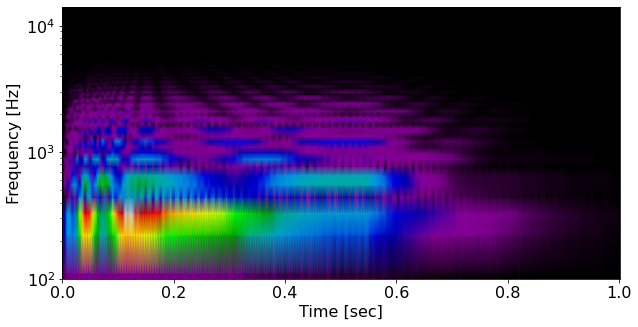

In [71]:
wind = envelope * my_saw

# Plot
f, t, Zxx = signal.stft(wind, fs, nperseg=400)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f, np.abs(Zxx), cmap='nipy_spectral', shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(100, 14000)
plt.yscale("log")
plt.show()

Audio(wind, rate=fs)

### 3.1. Play a song!

Let us try to play a melody with it, like for the guitar.

In [63]:
def trumpet(w,N):

    # Pitch envelope 1
    detune1 = np.zeros(N) 
    detune1[:3000] = -np.logspace(.7, -3 ,3000)

    # Pitch envelope 2
    detune2 = np.zeros(N) 
    detune2[:3000] = np.logspace(.3, -3 ,3000)

    lfo1 = sine(.1, .00071, 0, np.arange(N)) # Low freqency oscillator 1
    lfo2 = sine(.1, .00031, 0, np.arange(N)) # Low freqency oscillator 2
    
    my_saw1 = saw(1, w, detune1+lfo1, np.arange(N))
    my_saw1 = butter_pass_filter(my_saw1, np.array([2400]), fs, "low", order=3)

    my_saw2 = saw(1, w*1.001, detune2+lfo2, np.arange(N))
    my_saw2 = butter_pass_filter(my_saw2, np.array([2400]), fs, "low", order=3)

    my_saw = normalize(my_saw1+my_saw2)
    
    attack = 1500
    release = 2000

    envelope = np.ones(N) 
    envelope[:attack] = 1 - np.logspace(0, -2 ,attack)
    envelope[attack:] = 0.7 + 0.3*np.logspace(0, -10 , N-attack)
    envelope[-release:] = 0.7*np.logspace(0, -2, release)

    return my_saw * envelope

In [64]:
jingle = play_notes(tune, time_scale=0.04, rate=2*fs, wave_engine=trumpet)
Audio(jingle, rate=fs)